In [35]:
#!pip install torchsummary
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
!nvidia-smi

Fri Mar  8 16:36:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.10              Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        On  |   00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8              4W /  200W |     694MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [37]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


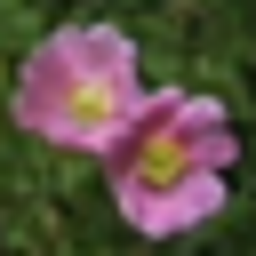

In [38]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [19, 70, 35]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCWC -> NWHC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

In [39]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f66f2b938e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f671c3d5390>}

In [40]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        return self.seq(input)

HIDDEN_SIZE = 32
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# NEW
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
model

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x32 and 3072x32)

In [ ]:
criterion = nn.CrossEntropyLoss()
# используется SGD c momentum
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [ ]:
EPOCHS = 250
REDRAW_EVERY = 10
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        #running_loss += loss.item()
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    #running_loss = 0.0
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #running_loss += loss.item()
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    #print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

  0%|          | 0/3000 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (12288x32 and 3072x10)

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          19     0.9940    0.9880    0.9910       500
          70     0.9804    0.9980    0.9891       500
          35     1.0000    0.9880    0.9940       500

    accuracy                         0.9913      1500
   macro avg     0.9914    0.9913    0.9913      1500
weighted avg     0.9914    0.9913    0.9913      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          19     0.9100    0.9100    0.9100       100
          70     0.8462    0.8800    0.8627       100
          35     0.9375    0.9000    0.9184       100

    accuracy                         0.8967       300
   macro avg     0.8979    0.8967    0.8970       300
weighted avg     0.8979    0.8967    0.8970       300

--------------------------------------------------


In [ ]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar_cnn.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_cnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [ ]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})